In [186]:
import xarray as xr
import glob
import matplotlib.pyplot as plt
import numpy as np

In [187]:
bcsd_models = glob.glob("/glade/p/ral/hap/common_data/BCSD/BCSD_mon_forc_nc/*rcp85*")
# example file = "conus_c5.miroc5_rcp85_r1i1p1.monthly.pr.1950.nc"
loca_models = glob.glob("/glade/p/ral/hap/common_data/LOCA/met/*/8th/historical/*/pr/")
# example file = "pr_day_MIROC5_historical_r1i1p1_19500101-19501231.LOCA_2016-04-02.8th.nc"


In [188]:
print(len(bcsd_models), len(loca_models))

29 32


In [189]:
def compute_interannual(model_search, varname="pr"):

    ds = xr.open_mfdataset(model_search)
    return ds[varname].resample(time="YS").sum(dim="time").std(dim="time").load()

In [190]:
def get_loca_interannual():
    file_search = "pr_day_*_historical_r*i*p*_19*.LOCA_*.8th.nc"

    data = []
    for l in loca_models:
        print(l.split("/")[8])
        data.append(compute_interannual(l+"/"+file_search))
        
    return xr.concat(data, dim="ens")*86400

In [191]:
def get_bcsd_interannual():
    file_search = "conus_c5.*_*_r*i*p*.monthly.pr.19*.nc"

    data = []
    for l in bcsd_models:
        print(l.split("/")[8].split("_")[0])
        data.append(compute_interannual(l+"/"+file_search))
        
    return xr.concat(data, dim="ens")


In [192]:
bcsd_data = get_bcsd_interannual()

fgoals-g2
miroc5
giss-e2-r
canesm2
mpi-esm-mr
mri-cgcm3
noresm1-m
csiro-mk3-6-0
cmcc-cm
ccsm4
gfdl-esm2g
gfdl-esm2m
inmcm4
ipsl-cm5b-lr
hadgem2-cc
bcc-csm1-1
cnrm-cm5
mpi-esm-lr
miroc-esm
hadgem2-es
hadgem2-ao
miroc-esm-chem
fio-esm
gfdl-cm3
access1-0
bcc-csm1-1-m
ipsl-cm5a-mr
cesm1-cam5
cesm1-bgc


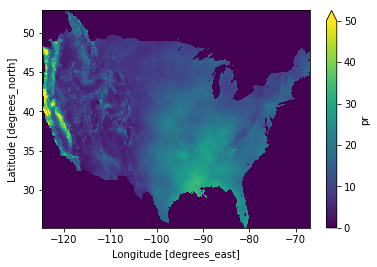

In [193]:
bcsd_data.std(dim="ens").plot(vmin=0, vmax=50)

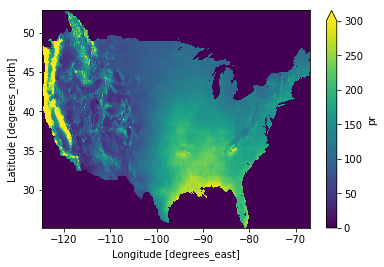

In [194]:
bcsd_data.mean(dim="ens").plot(vmin=0,vmax=300)

In [163]:
# Note: this will take a long(ish) time to run
loca_data = get_loca_interannual()

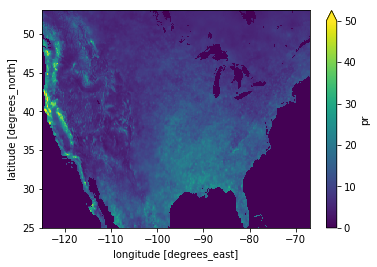

In [195]:

loca_data.std(dim="ens").plot(vmin=0, vmax=50)

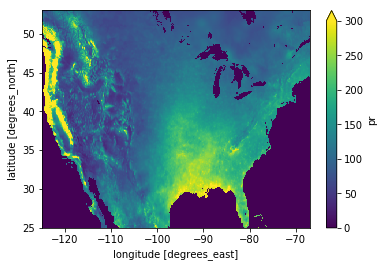

In [196]:
loca_data.mean(dim="ens").plot(vmin=0, vmax=300)

In [197]:
#  Single matching model (Miroc5) example if desired, see below for all matching models
# plt.figure(figsize=(15,6))
# print(bcsd_models[1])
# plt.subplot(1,2,1)
# bcsd_data[1].plot(vmin=0,vmax=300)
# print(loca_models[20])
# plt.subplot(1,2,2)
# loca_data[20].plot(vmin=0,vmax=300)

For some reason this:
`(loca_data[20][1:-1,2:]-bcsd_data[1]).plot()`
fails with a `MemoryError` so reverting to numpy arrays to plot.

In [198]:
tmp = loca_data[20].values[1:-1,2:] - bcsd_data[1].values

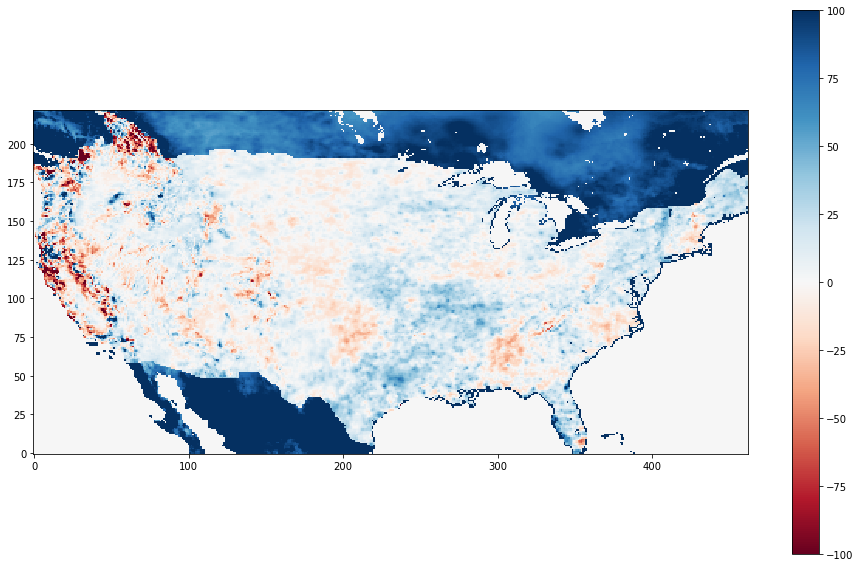

In [199]:
plt.figure(figsize=(16,10))
plt.imshow(tmp, vmin=-100,vmax=100, cmap=plt.cm.RdBu)
plt.colorbar()

Note that BCSD and LOCA have slightly different domains. The following shows a small patch over the olympic mountains from each to demonstrate that the grids match when LOCA is subset as : `[1:-1,2:]`

(222, 462)
(224, 464)


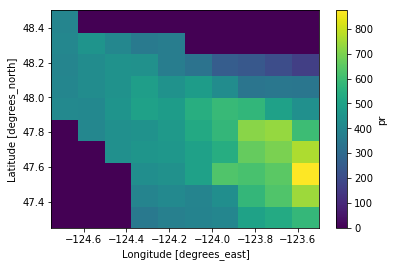

In [200]:
print(bcsd_data[1].shape)
print(loca_data[20].shape)
bcsd_data[1][-45:-35,:10].plot()

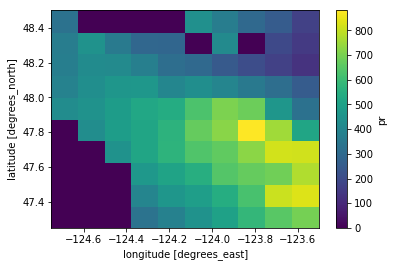

In [201]:
loca_data[1][1:-1,2:][-45:-35,:10].plot()

In [202]:
loca_mean = loca_data.mean(dim="ens")[1:-1,2:]
bcsd_mean = bcsd_data.mean(dim="ens")

loca_std = loca_data.std(dim="ens")[1:-1,2:]
bcsd_std = bcsd_data.std(dim="ens")


# (loca_data.mean(dim="ens")[1:-1,2:] - bcsd_data.mean(dim="ens")).plot()

In [203]:
delta = (loca_mean.values - bcsd_mean.values)
std_delta = (loca_std.values - bcsd_std.values)

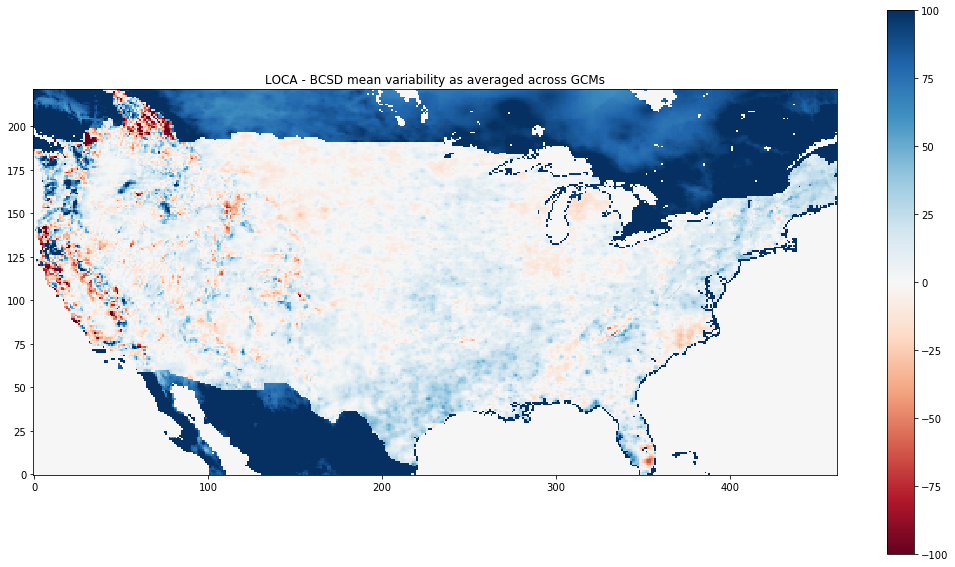

In [204]:
plt.figure(figsize=(18,10))
plt.imshow(delta, vmin=-100,vmax=100, cmap=plt.cm.RdBu)
plt.colorbar()
plt.title("LOCA - BCSD mean variability as averaged across GCMs");

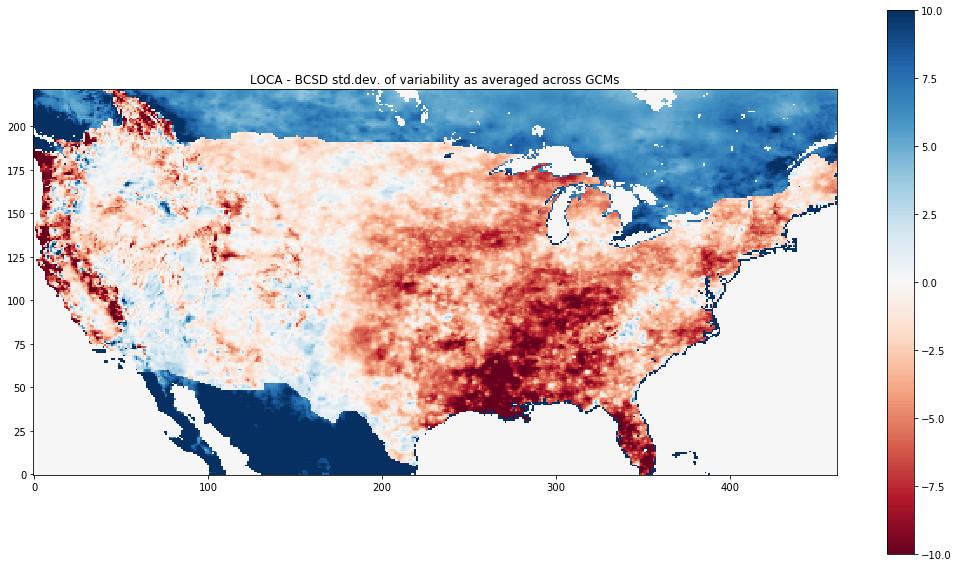

In [205]:
plt.figure(figsize=(18,10))
plt.imshow(std_delta, vmin=-10,vmax=10, cmap=plt.cm.RdBu)
plt.colorbar()
plt.title("LOCA - BCSD std.dev. of variability as averaged across GCMs");

In [206]:
loca_list = np.zeros(len(loca_models))
loca_list[:] = -1
for i,l in enumerate(loca_models):
    loca = l.split("/")[8]
    
    for bi,b in enumerate(bcsd_models):
        bcsd=b.split("/")[8].split("_rcp")[0]
        if (bcsd.upper()==loca.upper()):
            loca_list[i] = bi


In [207]:
print(np.sum(loca_list>=0))

27


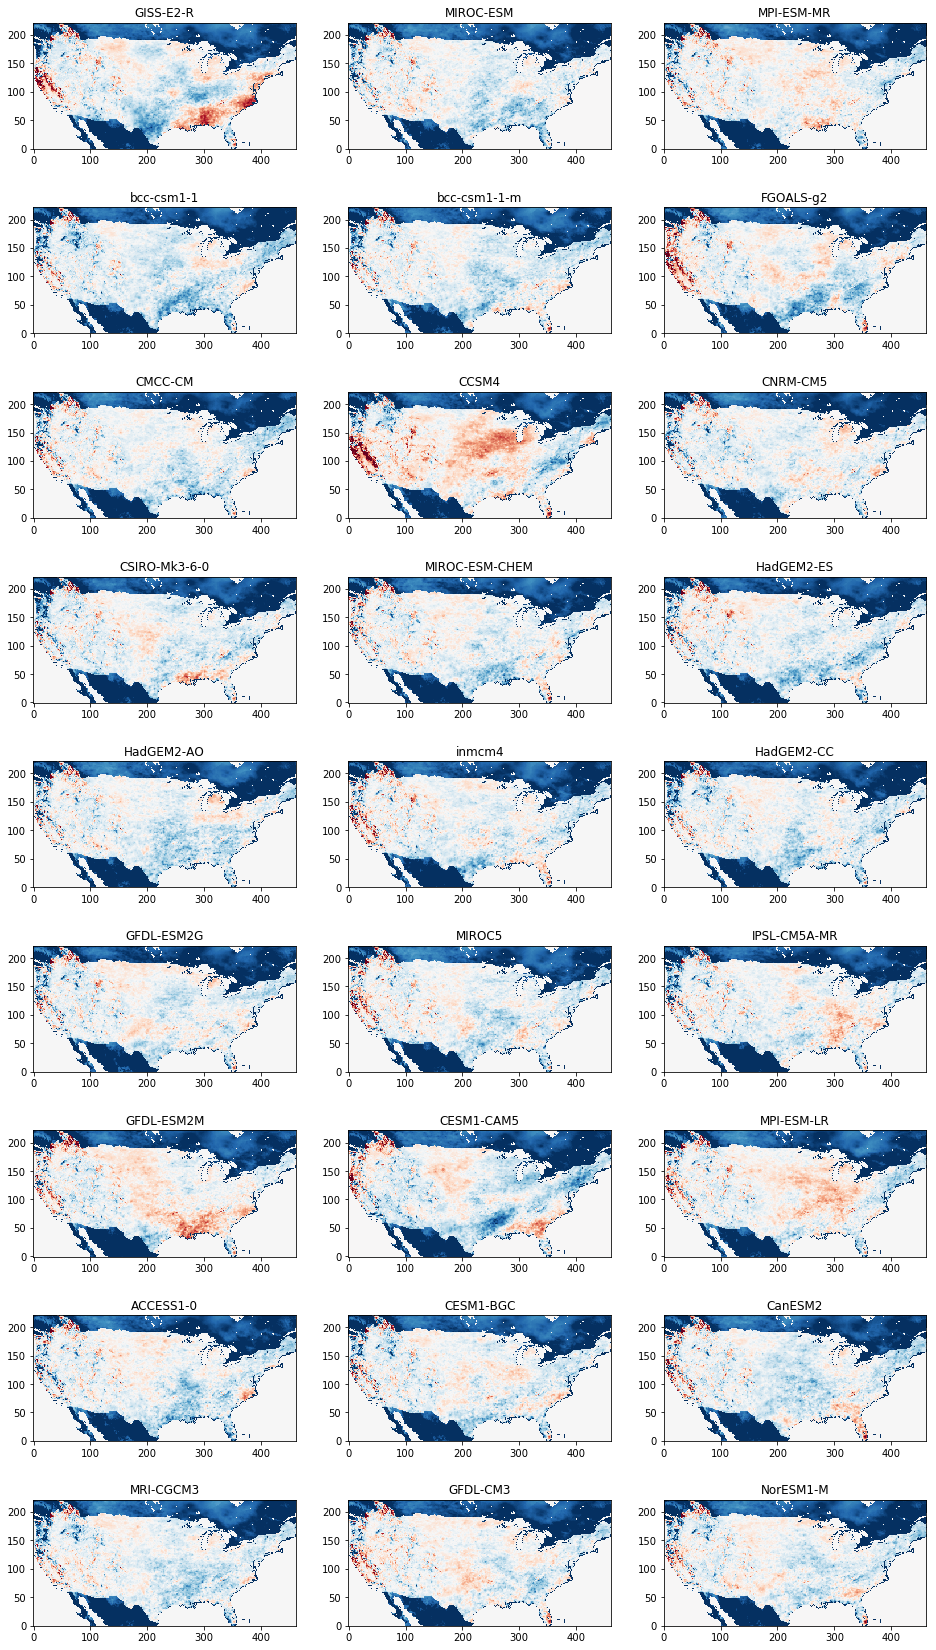

In [208]:
n=np.sum(loca_list>=0)
m=1
plt.figure(figsize=(16,30))

for i in range(len(loca_list)):
    if loca_list[i] >=0:
        plt.subplot(9,3,m)
        npl = loca_data[i].values[1:-1,2:]
        npb = bcsd_data[int(loca_list[i])].values
#         tmp = loca_data[i].values[1:-1,2:] - bcsd_data[loca_list[i]].values
        tmp = npl - npb
        plt.imshow(tmp,vmin=-100,vmax=100, cmap=plt.cm.RdBu)
        plt.title(loca_models[i].split("/")[8])
        m=m+1

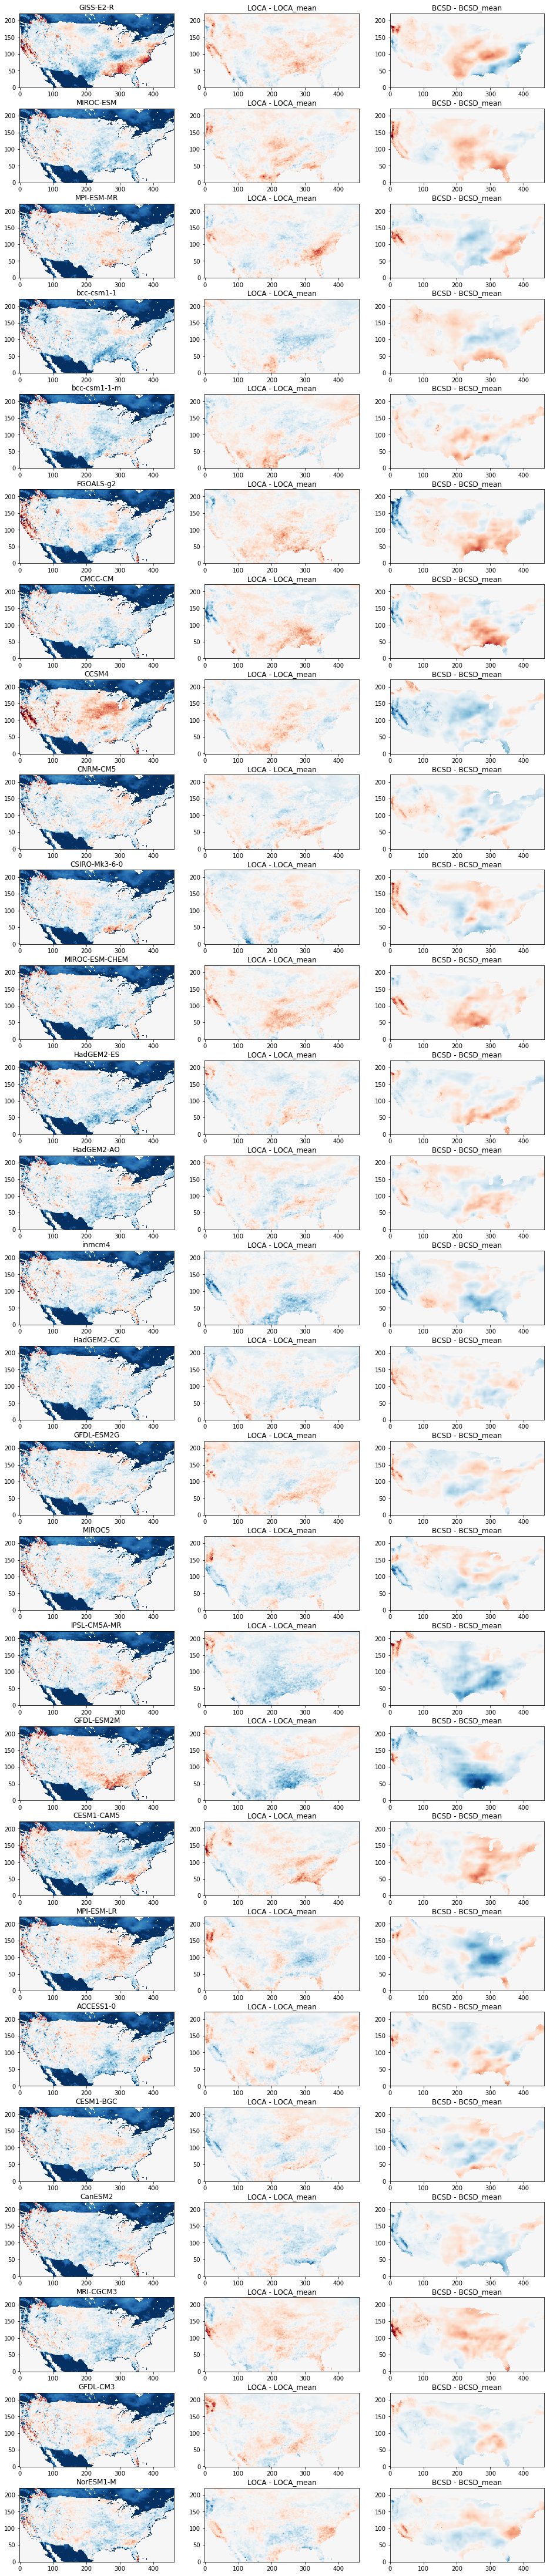

In [209]:
n=np.sum(loca_list>=0)
m=1
plt.figure(figsize=(16,80))

bmean = bcsd_data.mean(dim="ens")
lmean = loca_data.mean(dim="ens")

for i in range(len(loca_list)):
    if loca_list[i] >=0:
        plt.subplot(n,3,m)
        npl = loca_data[i].values[1:-1,2:]
        npb = bcsd_data[int(loca_list[i])].values
        tmp = npl - npb
        plt.imshow(tmp,vmin=-100,vmax=100, cmap=plt.cm.RdBu)
        plt.title(loca_models[i].split("/")[8])

        plt.subplot(n,3,m+1)
        tmp = npl - lmean.values[1:-1,2:]
        plt.imshow(tmp,vmin=-100,vmax=100, cmap=plt.cm.RdBu)
        plt.title("LOCA - LOCA_mean")

        plt.subplot(n,3,m+2)
        tmp = npb - bmean
        plt.imshow(tmp,vmin=-100,vmax=100, cmap=plt.cm.RdBu)
        plt.title("BCSD - BCSD_mean")

        m += 3 

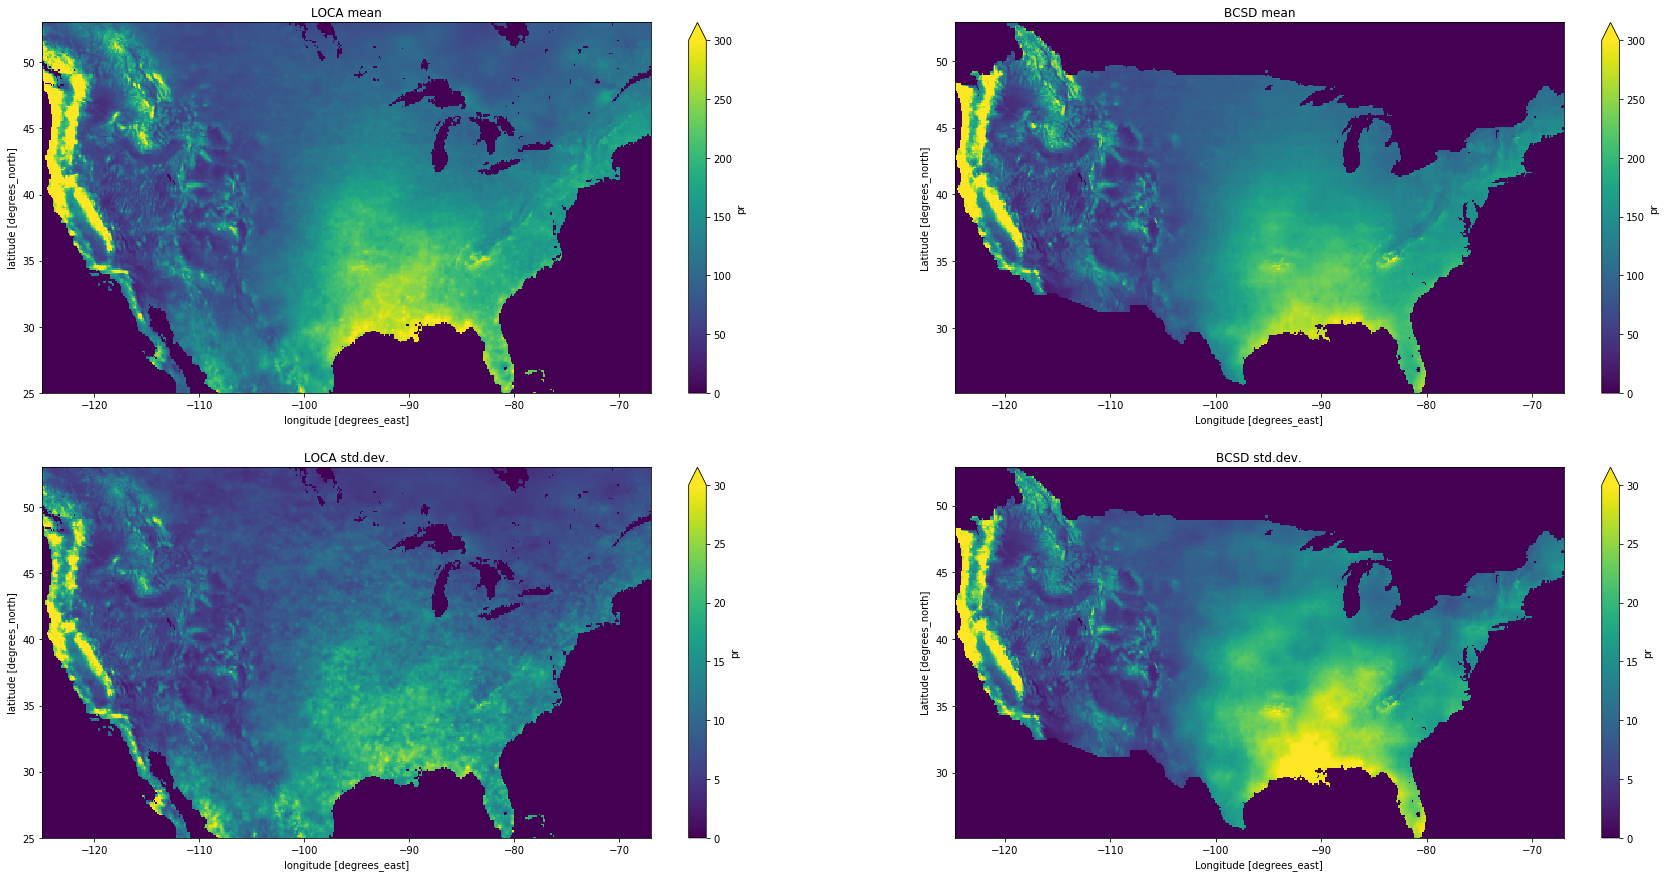

In [212]:
plt.figure(figsize=(30,15))
plt.subplot(2,2,1)
loca_data.mean(dim="ens").plot(vmin=0, vmax=300)
plt.title("LOCA mean")

plt.subplot(2,2,2)
bcsd_data.mean(dim="ens").plot(vmin=0, vmax=300)
plt.title("BCSD mean")

plt.subplot(2,2,3)
loca_data.std(dim="ens").plot(vmin=0, vmax=30)
plt.title("LOCA std.dev.")

plt.subplot(2,2,4)
bcsd_data.std(dim="ens").plot(vmin=0, vmax=30)
plt.title("BCSD std.dev.");